In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_train_est_A = pd.read_csv('train_est_A.csv')
df_train_obs_A = pd.read_csv('train_obs_A.csv')
df_test_A = pd.read_csv('X_test_A.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)

In [3]:
df_train_obs_A=df_train_obs_A.drop(columns=['snow_density:kgm3'])
df_train_est_A=df_train_est_A.drop(columns=['snow_density:kgm3','date_calc'])


In [4]:
df_train_obs_A = df_train_obs_A.fillna(0)
df_train_est_A = df_train_est_A.fillna(0)
df = pd.concat([df_train_obs_A,df_train_est_A])
df.index = pd.to_datetime(df.index)
df['hours'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df_test_A.index = pd.to_datetime(df_test_A.index)
df_test_A['hours'] = df_test_A.index.hour
df_test_A['day'] = df_test_A.index.day
df_test_A['month'] = df_test_A.index.month
df_test_A['year'] = df_test_A.index.year
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)

In [5]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_test_A = df_test_A.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [6]:
import lightgbm as lgb
model = lgb.LGBMRegressor(importance_type='gain')

In [8]:
X_train = df.drop(columns = 'pv_measurement')
y_train = df['pv_measurement']

In [9]:
model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7938
[LightGBM] [Info] Number of data points in the train set: 34085, number of used features: 46
[LightGBM] [Info] Start training from score 630.594707


LGBMRegressor(importance_type='gain')

In [11]:
feature_importance = model.feature_importances_
# Define a threshold for feature importance
threshold = 0.0005  # Adjust this value as needed

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
# Filter features above the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

# Create a new DataFrame with the selected features
X_selected = X_train[selected_features]
X_selected['pv_measurement'] = df['pv_measurement']


C:\Users\claxl\AppData\Local\Temp\ipykernel_32376\3299040996.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected['pv_measurement'] = df['pv_measurement']


In [12]:
from sklearn.neighbors import LocalOutlierFactor
df = X_selected
# Crea un modello di rilevamento delle anomalie
clf = LocalOutlierFactor(n_neighbors=20)

# Identifica i dati anomali
anomalies = clf.fit_predict(df)
df[anomalies == -1]
# Stampa i dati anomali
df = df[anomalies != -1]

In [50]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Sample DataFrame (replace this with your own dataset)
data = df

# Define the number of splits (e.g., 5 for 80-20 train-test splits)
n_splits = 2


# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)


In [51]:
def objective(trial):
    param = {
            'metric': 'mae', 
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators',10,1000),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,1e-1),
            'max_depth': trial.suggest_int('max_depth', 1,50),
            'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
            'verbosity': -1
        }
    model = lgb.LGBMRegressor(**param)
    maelist = []
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
        
        # Train the XGBoost model
        model.fit(X_train, y_train,eval_set=[(X_test,y_test)])

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)
        maelist.append(mae)
    # Return MAE
    mean_mae = np.mean(maelist)

    return mean_mae

In [52]:
import optuna
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)
study = optuna.create_study(direction='minimize',pruner=optuna.pruners.MedianPruner())

[I 2023-10-25 22:22:20,573] A new study created in memory with name: no-name-c84563d9-38f8-4bfb-b344-ec80d3ddb7e6


In [53]:
study.optimize(objective, n_trials=50)

Mean Absolute Error: 202.1730097769449


[I 2023-10-25 22:22:29,726] Trial 0 finished with value: 198.6855944528579 and parameters: {'n_estimators': 999, 'reg_alpha': 0.023939187841292026, 'reg_lambda': 0.0014843846569695188, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.022959690317277657, 'max_depth': 37, 'num_leaves': 939, 'min_child_samples': 288, 'min_data_per_groups': 25}. Best is trial 0 with value: 198.6855944528579.


Mean Absolute Error: 195.19817912877093
Mean Absolute Error: 205.49395868712105


[I 2023-10-25 22:22:34,814] Trial 1 finished with value: 201.28138285491883 and parameters: {'n_estimators': 663, 'reg_alpha': 8.327719076301493, 'reg_lambda': 0.008524585955128738, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.053390906365949405, 'max_depth': 46, 'num_leaves': 656, 'min_child_samples': 227, 'min_data_per_groups': 50}. Best is trial 0 with value: 198.6855944528579.


Mean Absolute Error: 197.06880702271658
Mean Absolute Error: 326.0476601469203


[I 2023-10-25 22:22:36,810] Trial 2 finished with value: 322.5894553078682 and parameters: {'n_estimators': 546, 'reg_alpha': 0.06489304403144841, 'reg_lambda': 6.1221712954780765, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0027706027380927614, 'max_depth': 24, 'num_leaves': 314, 'min_child_samples': 207, 'min_data_per_groups': 55}. Best is trial 0 with value: 198.6855944528579.


Mean Absolute Error: 319.1312504688161
Mean Absolute Error: 196.15162890967434


[I 2023-10-25 22:22:39,430] Trial 3 finished with value: 191.63769284434397 and parameters: {'n_estimators': 333, 'reg_alpha': 0.0010643574963013027, 'reg_lambda': 4.393426018924038, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.03179879133628896, 'max_depth': 26, 'num_leaves': 192, 'min_child_samples': 134, 'min_data_per_groups': 20}. Best is trial 3 with value: 191.63769284434397.


Mean Absolute Error: 187.1237567790136
Mean Absolute Error: 603.8018017303931


[I 2023-10-25 22:22:40,568] Trial 4 finished with value: 591.8198167850724 and parameters: {'n_estimators': 326, 'reg_alpha': 3.7535332715695375, 'reg_lambda': 0.01520111049653068, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.0013893805460194128, 'max_depth': 30, 'num_leaves': 17, 'min_child_samples': 257, 'min_data_per_groups': 17}. Best is trial 3 with value: 191.63769284434397.


Mean Absolute Error: 579.8378318397516
Mean Absolute Error: 218.17943954036352


[I 2023-10-25 22:22:43,326] Trial 5 finished with value: 209.67416311387262 and parameters: {'n_estimators': 997, 'reg_alpha': 0.1841914126189133, 'reg_lambda': 0.11468463540763066, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.06731368565303134, 'max_depth': 4, 'num_leaves': 872, 'min_child_samples': 161, 'min_data_per_groups': 38}. Best is trial 3 with value: 191.63769284434397.


Mean Absolute Error: 201.16888668738176
Mean Absolute Error: 191.31995624822446


[I 2023-10-25 22:22:49,397] Trial 6 finished with value: 189.2222771759349 and parameters: {'n_estimators': 541, 'reg_alpha': 6.236043623204292, 'reg_lambda': 0.0013077472959952285, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.011071307696512812, 'max_depth': 27, 'num_leaves': 503, 'min_child_samples': 47, 'min_data_per_groups': 47}. Best is trial 6 with value: 189.2222771759349.


Mean Absolute Error: 187.12459810364533
Mean Absolute Error: 197.31964117258042


[I 2023-10-25 22:22:53,298] Trial 7 finished with value: 193.12618191561572 and parameters: {'n_estimators': 945, 'reg_alpha': 0.9398451561603013, 'reg_lambda': 0.0407364323558598, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01152125742528997, 'max_depth': 8, 'num_leaves': 555, 'min_child_samples': 185, 'min_data_per_groups': 41}. Best is trial 6 with value: 189.2222771759349.


Mean Absolute Error: 188.93272265865102
Mean Absolute Error: 209.2550464823342


[I 2023-10-25 22:23:02,558] Trial 8 finished with value: 203.87545085090358 and parameters: {'n_estimators': 927, 'reg_alpha': 0.0032735456843014064, 'reg_lambda': 2.932629532825441, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.05784168052505329, 'max_depth': 45, 'num_leaves': 409, 'min_child_samples': 109, 'min_data_per_groups': 43}. Best is trial 6 with value: 189.2222771759349.


Mean Absolute Error: 198.49585521947296
Mean Absolute Error: 476.39095311537386


[I 2023-10-25 22:23:04,304] Trial 9 finished with value: 470.0157128318976 and parameters: {'n_estimators': 859, 'reg_alpha': 0.16086481316332152, 'reg_lambda': 9.807742931360842, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.00098568875938991, 'max_depth': 3, 'num_leaves': 387, 'min_child_samples': 133, 'min_data_per_groups': 44}. Best is trial 6 with value: 189.2222771759349.


Mean Absolute Error: 463.6404725484213
Mean Absolute Error: 856.478799698588


[I 2023-10-25 22:23:06,560] Trial 10 finished with value: 838.2620678362825 and parameters: {'n_estimators': 99, 'reg_alpha': 1.4774562888167135, 'reg_lambda': 0.0010787164717838602, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.00016991667136416534, 'max_depth': 16, 'num_leaves': 709, 'min_child_samples': 15, 'min_data_per_groups': 96}. Best is trial 6 with value: 189.2222771759349.


Mean Absolute Error: 820.0453359739772
Mean Absolute Error: 216.0924199530382


[I 2023-10-25 22:23:10,105] Trial 11 finished with value: 213.1215783123317 and parameters: {'n_estimators': 344, 'reg_alpha': 0.0011955263280820205, 'reg_lambda': 0.5585672805245696, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008453156304260186, 'max_depth': 23, 'num_leaves': 151, 'min_child_samples': 55, 'min_data_per_groups': 2}. Best is trial 6 with value: 189.2222771759349.


Mean Absolute Error: 210.15073667162522
Mean Absolute Error: 192.56460704034677


[I 2023-10-25 22:23:13,103] Trial 12 finished with value: 191.5010480871366 and parameters: {'n_estimators': 338, 'reg_alpha': 0.010480867056377562, 'reg_lambda': 0.46236847468944464, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.013046172452641214, 'max_depth': 34, 'num_leaves': 228, 'min_child_samples': 84, 'min_data_per_groups': 76}. Best is trial 6 with value: 189.2222771759349.


Mean Absolute Error: 190.43748913392645
Mean Absolute Error: 190.32481346122273


[I 2023-10-25 22:23:19,103] Trial 13 finished with value: 188.56964444482693 and parameters: {'n_estimators': 645, 'reg_alpha': 0.0144805370778528, 'reg_lambda': 0.27842969263408274, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.007973492820675627, 'max_depth': 37, 'num_leaves': 513, 'min_child_samples': 74, 'min_data_per_groups': 68}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 186.81447542843114
Mean Absolute Error: 218.0067043242973


[I 2023-10-25 22:23:37,793] Trial 14 finished with value: 216.7031847433517 and parameters: {'n_estimators': 650, 'reg_alpha': 0.617904094076111, 'reg_lambda': 0.0061397224676204825, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.004453345515696725, 'max_depth': 39, 'num_leaves': 530, 'min_child_samples': 7, 'min_data_per_groups': 68}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 215.39966516240608
Mean Absolute Error: 193.41198951520227


[I 2023-10-25 22:23:43,588] Trial 15 finished with value: 192.130786529747 and parameters: {'n_estimators': 758, 'reg_alpha': 0.03627440598947056, 'reg_lambda': 0.10074125549059829, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.005670884411255935, 'max_depth': 15, 'num_leaves': 672, 'min_child_samples': 77, 'min_data_per_groups': 68}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 190.8495835442918
Mean Absolute Error: 194.1720482248999


[I 2023-10-25 22:23:50,394] Trial 16 finished with value: 191.99319298556975 and parameters: {'n_estimators': 464, 'reg_alpha': 0.31333203701446466, 'reg_lambda': 0.0027480236272662845, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.017838417398276334, 'max_depth': 43, 'num_leaves': 455, 'min_child_samples': 36, 'min_data_per_groups': 89}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 189.81433774623957
Mean Absolute Error: 198.5884618958837


[I 2023-10-25 22:23:57,374] Trial 17 finished with value: 193.39124558101378 and parameters: {'n_estimators': 542, 'reg_alpha': 0.07039735163035736, 'reg_lambda': 0.02893828665380331, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.028779889472031486, 'max_depth': 50, 'num_leaves': 781, 'min_child_samples': 90, 'min_data_per_groups': 61}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 188.19402926614381
Mean Absolute Error: 202.34707593562527


[I 2023-10-25 22:23:59,339] Trial 18 finished with value: 198.78379500340984 and parameters: {'n_estimators': 180, 'reg_alpha': 8.65685175499198, 'reg_lambda': 0.003566750725671922, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.09308461316219296, 'max_depth': 31, 'num_leaves': 548, 'min_child_samples': 48, 'min_data_per_groups': 81}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 195.2205140711944
Mean Absolute Error: 191.01765660243316


[I 2023-10-25 22:24:04,672] Trial 19 finished with value: 189.19261310706304 and parameters: {'n_estimators': 774, 'reg_alpha': 0.011621737982568194, 'reg_lambda': 0.01600848661645202, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.006621614579441991, 'max_depth': 16, 'num_leaves': 318, 'min_child_samples': 113, 'min_data_per_groups': 32}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 187.36756961169291
Mean Absolute Error: 258.9390973130209


[I 2023-10-25 22:24:09,943] Trial 20 finished with value: 255.67142269246432 and parameters: {'n_estimators': 795, 'reg_alpha': 0.008099881964728906, 'reg_lambda': 0.19498757166664818, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.002627724167323087, 'max_depth': 17, 'num_leaves': 311, 'min_child_samples': 108, 'min_data_per_groups': 29}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 252.4037480719077
Mean Absolute Error: 193.71083298561075


[I 2023-10-25 22:24:16,221] Trial 21 finished with value: 190.2882147354124 and parameters: {'n_estimators': 689, 'reg_alpha': 0.03324893211471606, 'reg_lambda': 0.019301060127630425, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.01151275651263314, 'max_depth': 19, 'num_leaves': 323, 'min_child_samples': 63, 'min_data_per_groups': 32}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 186.86559648521404
Mean Absolute Error: 211.53822730090394


[I 2023-10-25 22:24:19,642] Trial 22 finished with value: 209.84789169313044 and parameters: {'n_estimators': 465, 'reg_alpha': 0.012193946159364255, 'reg_lambda': 0.044331349692854884, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.006665829183594585, 'max_depth': 11, 'num_leaves': 483, 'min_child_samples': 113, 'min_data_per_groups': 57}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 208.15755608535693
Mean Absolute Error: 196.97411342922845


[I 2023-10-25 22:24:25,045] Trial 23 finished with value: 195.04546433157896 and parameters: {'n_estimators': 604, 'reg_alpha': 0.12183924972161417, 'reg_lambda': 0.0027918013190189063, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.006703652681793511, 'max_depth': 28, 'num_leaves': 99, 'min_child_samples': 33, 'min_data_per_groups': 13}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 193.1168152339295
Mean Absolute Error: 195.84962076451163


[I 2023-10-25 22:24:30,353] Trial 24 finished with value: 192.1009336456617 and parameters: {'n_estimators': 764, 'reg_alpha': 0.00484367141480667, 'reg_lambda': 0.00922134743831638, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.015123787101665754, 'max_depth': 21, 'num_leaves': 604, 'min_child_samples': 150, 'min_data_per_groups': 66}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 188.35224652681177
Mean Absolute Error: 224.02098043237487


[I 2023-10-25 22:24:37,488] Trial 25 finished with value: 222.05207101214657 and parameters: {'n_estimators': 861, 'reg_alpha': 0.020016323341030023, 'reg_lambda': 0.005093933656603581, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0031280043015361734, 'max_depth': 34, 'num_leaves': 412, 'min_child_samples': 75, 'min_data_per_groups': 50}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 220.08316159191827
Mean Absolute Error: 198.00381029930182


[I 2023-10-25 22:24:43,463] Trial 26 finished with value: 192.98396570219683 and parameters: {'n_estimators': 720, 'reg_alpha': 0.34595383646779587, 'reg_lambda': 0.0018089393280894212, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.03192790982875481, 'max_depth': 13, 'num_leaves': 267, 'min_child_samples': 31, 'min_data_per_groups': 76}. Best is trial 13 with value: 188.56964444482693.


Mean Absolute Error: 187.96412110509186
Mean Absolute Error: 191.7974358387658


[I 2023-10-25 22:24:49,247] Trial 27 finished with value: 188.51120998292885 and parameters: {'n_estimators': 602, 'reg_alpha': 0.05309828281447404, 'reg_lambda': 0.017193372003039015, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.01080716367280582, 'max_depth': 39, 'num_leaves': 746, 'min_child_samples': 96, 'min_data_per_groups': 35}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 185.2249841270919
Mean Absolute Error: 216.19858432280873


[I 2023-10-25 22:24:52,776] Trial 28 finished with value: 215.26526058868933 and parameters: {'n_estimators': 607, 'reg_alpha': 0.058349153679430416, 'reg_lambda': 0.052939943023386504, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.004915080721058166, 'max_depth': 41, 'num_leaves': 794, 'min_child_samples': 171, 'min_data_per_groups': 35}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 214.33193685456996
Mean Absolute Error: 199.89152756772629


[I 2023-10-25 22:25:00,754] Trial 29 finished with value: 195.3210629148557 and parameters: {'n_estimators': 840, 'reg_alpha': 0.03410534485391473, 'reg_lambda': 0.01320360531412456, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.023373175563783093, 'max_depth': 35, 'num_leaves': 925, 'min_child_samples': 133, 'min_data_per_groups': 25}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 190.75059826198512
Mean Absolute Error: 192.67058047981524


[I 2023-10-25 22:25:05,049] Trial 30 finished with value: 189.28889902225694 and parameters: {'n_estimators': 416, 'reg_alpha': 0.017647260526640753, 'reg_lambda': 0.02125328612947736, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.01698644685862801, 'max_depth': 49, 'num_leaves': 811, 'min_child_samples': 97, 'min_data_per_groups': 7}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 185.90721756469867
Mean Absolute Error: 192.6996591306357


[I 2023-10-25 22:25:13,886] Trial 31 finished with value: 189.4418377198975 and parameters: {'n_estimators': 594, 'reg_alpha': 0.02342684615013931, 'reg_lambda': 0.0011298501215333931, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.009257732424178827, 'max_depth': 38, 'num_leaves': 604, 'min_child_samples': 65, 'min_data_per_groups': 27}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 186.18401630915932
Mean Absolute Error: 191.8716196809228


[I 2023-10-25 22:25:18,325] Trial 32 finished with value: 190.38270669297722 and parameters: {'n_estimators': 506, 'reg_alpha': 0.09124209399905064, 'reg_lambda': 0.007781612248725846, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.00908494196402401, 'max_depth': 30, 'num_leaves': 729, 'min_child_samples': 118, 'min_data_per_groups': 50}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 188.89379370503164
Mean Absolute Error: 197.05449086989495


[I 2023-10-25 22:25:28,634] Trial 33 finished with value: 193.64184323915867 and parameters: {'n_estimators': 680, 'reg_alpha': 4.113748119190441, 'reg_lambda': 0.0016937508749270685, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.020254777089099167, 'max_depth': 36, 'num_leaves': 475, 'min_child_samples': 50, 'min_data_per_groups': 44}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 190.22919560842243
Mean Absolute Error: 204.5565068796227


[I 2023-10-25 22:25:35,494] Trial 34 finished with value: 198.1601138132193 and parameters: {'n_estimators': 622, 'reg_alpha': 0.050535031489043106, 'reg_lambda': 0.012454410660989266, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.0391653317650911, 'max_depth': 25, 'num_leaves': 981, 'min_child_samples': 94, 'min_data_per_groups': 55}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 191.7637207468159
Mean Absolute Error: 194.70141486918823


[I 2023-10-25 22:25:40,173] Trial 35 finished with value: 191.9099763878315 and parameters: {'n_estimators': 563, 'reg_alpha': 0.10044623106837511, 'reg_lambda': 0.0038450135356604916, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.014027008529375076, 'max_depth': 41, 'num_leaves': 618, 'min_child_samples': 196, 'min_data_per_groups': 21}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 189.11853790647478
Mean Absolute Error: 224.39954201058183


[I 2023-10-25 22:25:43,890] Trial 36 finished with value: 224.43477793655933 and parameters: {'n_estimators': 726, 'reg_alpha': 0.01521937293222664, 'reg_lambda': 0.006656867040423947, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0038759599955706953, 'max_depth': 28, 'num_leaves': 353, 'min_child_samples': 229, 'min_data_per_groups': 34}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 224.47001386253686
Mean Absolute Error: 198.42879551326916


[I 2023-10-25 22:25:45,507] Trial 37 finished with value: 194.6535205629075 and parameters: {'n_estimators': 404, 'reg_alpha': 0.007022544636609189, 'reg_lambda': 0.010237855377291752, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.025664428993604035, 'max_depth': 8, 'num_leaves': 261, 'min_child_samples': 144, 'min_data_per_groups': 49}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 190.87824561254578
Mean Absolute Error: 279.175725791577


[I 2023-10-25 22:25:46,542] Trial 38 finished with value: 277.57474799694626 and parameters: {'n_estimators': 224, 'reg_alpha': 0.02715202170933191, 'reg_lambda': 0.02302479496032785, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.008511806734688042, 'max_depth': 21, 'num_leaves': 36, 'min_child_samples': 279, 'min_data_per_groups': 62}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 275.97377020231556
Mean Absolute Error: 203.00745502522605


[I 2023-10-25 22:25:51,512] Trial 39 finished with value: 198.844922376709 and parameters: {'n_estimators': 529, 'reg_alpha': 0.047123879148949215, 'reg_lambda': 0.06435645519363825, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.0424497689518871, 'max_depth': 32, 'num_leaves': 865, 'min_child_samples': 126, 'min_data_per_groups': 16}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 194.682389728192
Mean Absolute Error: 260.0735303423278


[I 2023-10-25 22:26:10,509] Trial 40 finished with value: 255.21489164282514 and parameters: {'n_estimators': 812, 'reg_alpha': 4.153543294595801, 'reg_lambda': 0.03021344131176236, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.0025383353639046808, 'max_depth': 46, 'num_leaves': 430, 'min_child_samples': 21, 'min_data_per_groups': 40}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 250.35625294332246
Mean Absolute Error: 193.97094260778724


[I 2023-10-25 22:26:14,934] Trial 41 finished with value: 189.88567592012575 and parameters: {'n_estimators': 425, 'reg_alpha': 0.017426290240346597, 'reg_lambda': 0.01984292130161791, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.019603744324702153, 'max_depth': 44, 'num_leaves': 808, 'min_child_samples': 99, 'min_data_per_groups': 3}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 185.80040923246426
Mean Absolute Error: 193.94820045536127


[I 2023-10-25 22:26:20,969] Trial 42 finished with value: 189.6870836581897 and parameters: {'n_estimators': 426, 'reg_alpha': 0.015273335977144567, 'reg_lambda': 0.014992083805627705, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.016217052431210563, 'max_depth': 48, 'num_leaves': 874, 'min_child_samples': 72, 'min_data_per_groups': 38}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 185.4259668610181
Mean Absolute Error: 223.04301118141535


[I 2023-10-25 22:26:23,261] Trial 43 finished with value: 220.413990537085 and parameters: {'n_estimators': 271, 'reg_alpha': 0.023719363183570933, 'reg_lambda': 0.03471399186270746, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.01007731120937232, 'max_depth': 49, 'num_leaves': 742, 'min_child_samples': 97, 'min_data_per_groups': 7}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 217.78496989275462
Mean Absolute Error: 206.81187463142456


[I 2023-10-25 22:26:28,598] Trial 44 finished with value: 204.8469820367264 and parameters: {'n_estimators': 476, 'reg_alpha': 0.006403319116131432, 'reg_lambda': 0.004884164481423021, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.006834551097146356, 'max_depth': 40, 'num_leaves': 678, 'min_child_samples': 85, 'min_data_per_groups': 12}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 202.88208944202822
Mean Absolute Error: 194.5577445698271


[I 2023-10-25 22:26:36,916] Trial 45 finished with value: 191.88510378556504 and parameters: {'n_estimators': 920, 'reg_alpha': 1.7533334448013134, 'reg_lambda': 0.07287222107303316, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012955846358887555, 'max_depth': 46, 'num_leaves': 536, 'min_child_samples': 165, 'min_data_per_groups': 22}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 189.21246300130298
Mean Absolute Error: 277.7854502229024


[I 2023-10-25 22:26:42,623] Trial 46 finished with value: 273.11767270332973 and parameters: {'n_estimators': 386, 'reg_alpha': 0.00990515254335687, 'reg_lambda': 0.008677725527146919, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.004765091580837835, 'max_depth': 43, 'num_leaves': 632, 'min_child_samples': 48, 'min_data_per_groups': 47}. Best is trial 27 with value: 188.51120998292885.


Mean Absolute Error: 268.449895183757
Mean Absolute Error: 191.48834876677532


[I 2023-10-25 22:26:48,362] Trial 47 finished with value: 188.38433481929363 and parameters: {'n_estimators': 653, 'reg_alpha': 0.17727579179018738, 'reg_lambda': 0.152845059008684, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012013898286657493, 'max_depth': 28, 'num_leaves': 845, 'min_child_samples': 104, 'min_data_per_groups': 73}. Best is trial 47 with value: 188.38433481929363.


Mean Absolute Error: 185.28032087181194
Mean Absolute Error: 190.77367160013324


[I 2023-10-25 22:26:53,453] Trial 48 finished with value: 188.13035359276574 and parameters: {'n_estimators': 648, 'reg_alpha': 0.18734665099633893, 'reg_lambda': 0.15271069876903318, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.011131612016333637, 'max_depth': 27, 'num_leaves': 177, 'min_child_samples': 122, 'min_data_per_groups': 75}. Best is trial 48 with value: 188.13035359276574.


Mean Absolute Error: 185.48703558539822
Mean Absolute Error: 264.45899013326465


[I 2023-10-25 22:26:54,624] Trial 49 finished with value: 268.46895070307113 and parameters: {'n_estimators': 664, 'reg_alpha': 0.17549225240463273, 'reg_lambda': 0.15883014426288708, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.005979591717367344, 'max_depth': 1, 'num_leaves': 113, 'min_child_samples': 125, 'min_data_per_groups': 84}. Best is trial 48 with value: 188.13035359276574.


Mean Absolute Error: 272.4789112728776


In [54]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

  Value: 188.13035359276574
{'n_estimators': 648, 'reg_alpha': 0.18734665099633893, 'reg_lambda': 0.15271069876903318, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.011131612016333637, 'max_depth': 27, 'num_leaves': 177, 'min_child_samples': 122, 'min_data_per_groups': 75}


In [55]:
    param = {'n_estimators': 648, 'reg_alpha': 0.18734665099633893, 'reg_lambda': 0.15271069876903318, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.011131612016333637, 'max_depth': 27, 'num_leaves': 177, 'min_child_samples': 122, 'min_data_per_groups': 75}

In [56]:
model_A = lgb.LGBMRegressor(**param)

In [57]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [58]:
model_A.fit(X_train,y_train)
df_test_A = df_test_A[selected_features]
y_pred_A = model_A.predict(df_test_A)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7283
[LightGBM] [Info] Number of data points in the train set: 33444, number of used features: 36
[LightGBM] [Info] Start training from score 641.357878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


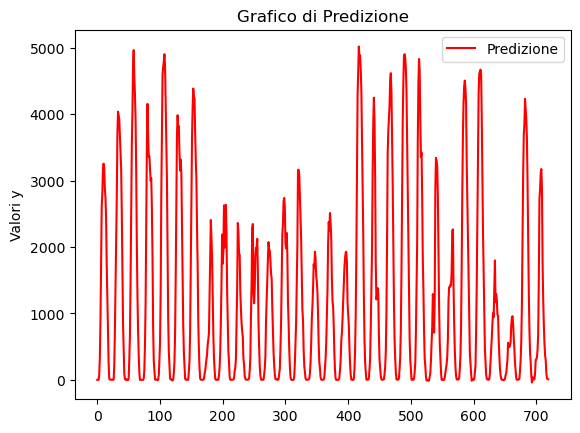

In [59]:
plt.plot(range(len(y_pred_A)), y_pred_A, label='Predizione', color='red', linestyle='-')

# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [60]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [61]:
threshold = 0.05
df['Prediction'] = df['Prediction'].apply(lambda x: 0 if x < threshold else x)

In [62]:
df.to_csv('A.csv')